# 4D Sleipner seismic inversion (surveys 1994 and 2001) in 3D

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import segyio
import pyvista as pv
from pylops.avo.poststack import PoststackLinearModelling
from prox4d.utils_ import *
import time
import cupy as cp
from prox4d.jointinv4Dgpu import jis_4D_gpu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Sub-volume of size 200 x 200 x 80
f94 = segyio.open('../data/Sleipner/94p07ful.sgy')
d94 = segyio.cube(f94)
b = d94.transpose(2, 1, 0)[400:600, 100:300, 100:180]  # Baseline section
m = np.load('../data/Sleipner/Sleipner_01_timeshifted_ts0_680.npy')[400:600, 100:300,
    100:180]  # time-shift regularization in 2D
# m = np.load('../../data/Sleipner/Sleipner_01_timeshifted_ts0_680B.npy')[:680] # time-shift regularization in 3D
nt, nx, ny = m.shape
dt = 0.002
wav_base = np.load('../data/Sleipner/Sleipner_wavelet_94.npy')
wav_base_cp = cp.asanyarray(wav_base, dtype='float32')
wav_moni = np.load('../data/Sleipner/Sleipner_wavelet_01.npy')
wav_moni_cp = cp.asanyarray(wav_moni, dtype='float32')
imp_model = np.load('../data/Sleipner/Sleipner_impedance_model.npy')
imp_model = np.repeat(imp_model[:, :, np.newaxis], m.shape[-1], axis=-1)[400:600, 100:300]  #make 3D model
mback = np.log(imp_model)

imp_L2b = np.load('../data/Sleipner/Sleipner_l2inv_il_120.npy')  # used just as reference for plotting

Lop_base_cp = PoststackLinearModelling(wav_base_cp, nt0=nt, spatdims=(nx, ny), explicit=True)
Lop_mon_cp = PoststackLinearModelling(wav_moni_cp, nt0=nt, spatdims=(nx, ny), explicit=True)
print(m.shape, b.shape, mback.shape)

(200, 200, 80) (200, 200, 80) (200, 200, 80)


In [ ]:
# # Sub-volume of size 675 x 468 x 29 (a portion of underburden was removed)
# f94 = segyio.open('../../data/Sleipner/94p07ful.sgy')
# d94 = segyio.cube(f94)
# b = d94.transpose(2, 1, 0)[:675]  # Baseline section
# m = np.load('../../data/Sleipner/Sleipner_01_timeshifted_ts0_680.npy')[:675]  # time-shift regularization in 2D
# # m = np.load('../../data/Sleipner/Sleipner_01_timeshifted_ts0_680B.npy')[:680] # time-shift regularization in 3D
# nt, nx, ny = m.shape
# dt = 0.002
# wav_base = np.load('../../data/Sleipner/Sleipner_wavelet_94.npy')
# wav_base_cp = cp.asanyarray(wav_base, dtype='float32')
# wav_moni = np.load('../../data/Sleipner/Sleipner_wavelet_01.npy')
# wav_moni_cp = cp.asanyarray(wav_moni, dtype='float32')
# imp_model = np.load('../../data/Sleipner/Sleipner_impedance_model.npy')[:675]
# imp_model = np.repeat(imp_model[:, :, np.newaxis], m.shape[-1], axis=-1)  #make 3D model
# mback = np.log(imp_model)
#
# imp_L2b = np.load('../../data/Sleipner/Sleipner_l2inv_il_120.npy')  # used just as reference for plotting
#
# Lop_base_cp = PoststackLinearModelling(wav_base_cp, nt0=nt, spatdims=(nx, ny), explicit=True)
# Lop_mon_cp = PoststackLinearModelling(wav_moni_cp, nt0=nt, spatdims=(nx, ny), explicit=True)
# print(m.shape, b.shape, mback.shape)

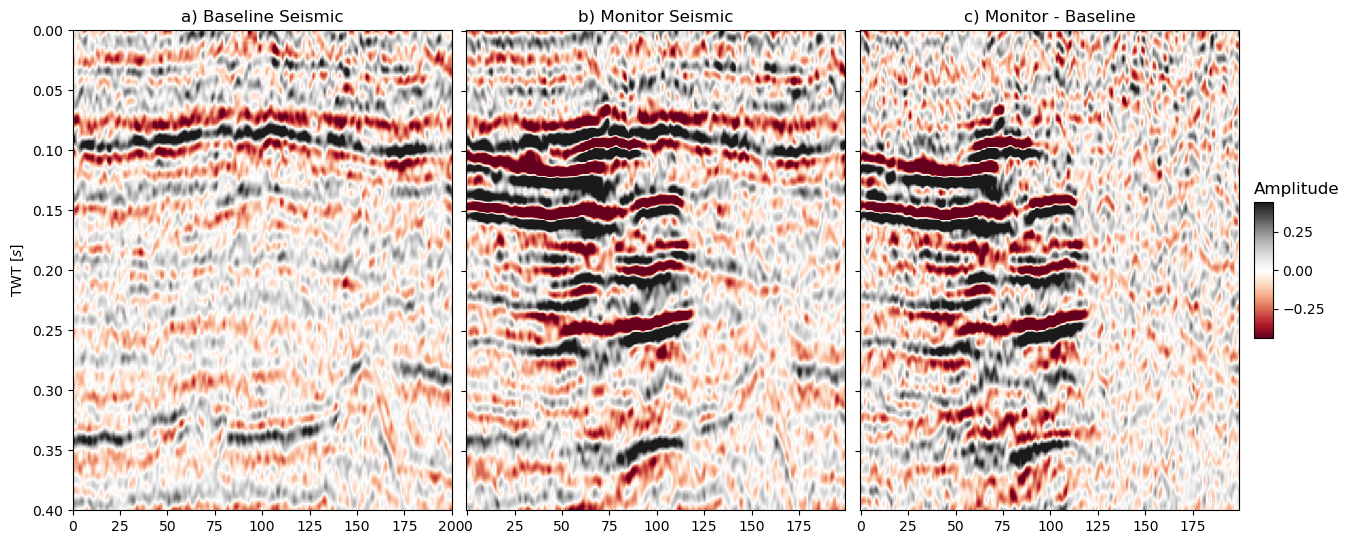

In [49]:
i = 10  # sample inline
plotter_4D(b[:, :, i], m[:, :, i], type='seismic', dt=dt, height=6, cmap='RdGy')

Working with alpha=0.200000,  beta=2.000000,  delta=5.000000
Iteration 0...
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.blockdiag.BlockDiag'>
Additional vector (z): None
tau = 1.0		mu = 0.055
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   8.19839e+00   4.460e+04   1.109e+05   0.000e+00       1.555e+05
     2   8.19574e+00   2.203e+04   1.517e+05   0.000e+00       1.738e+05
     3   8.19561e+00   1.629e+04   1.659e+05   0.000e+00       1.822e+05
     4   8.19504e+00   1.436e+04   1.684e+05   0.000e+00       1.828e+05
     5   8.19347e+00   1.379e+04   1.656e+05   0.000e+00       1.794e+05
     6   8.19101e+00   1.392e+04   1.604e+05   0.000e+00       1.743e+05
     7   8.18789e+00   1.447e+04   1.541e+05

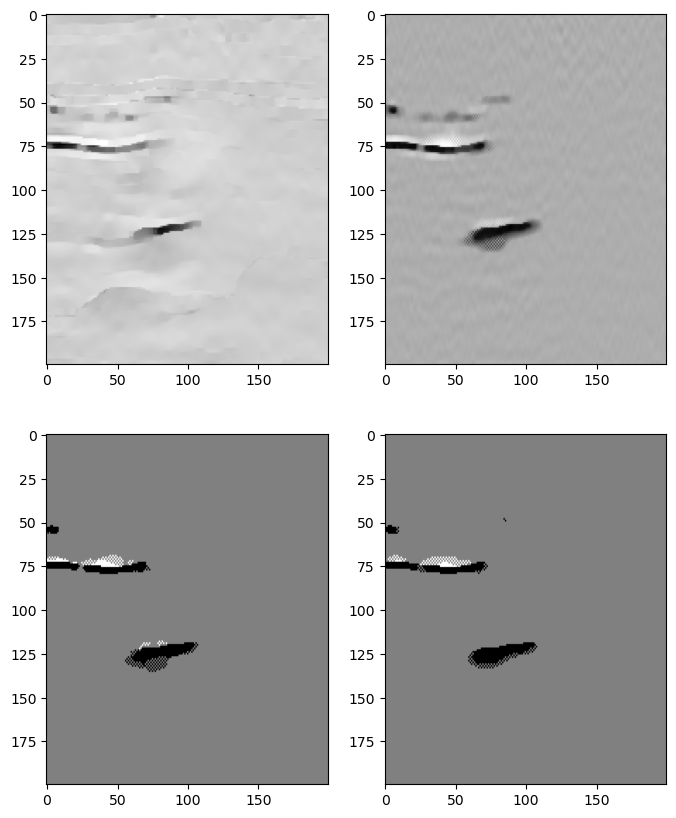

277.72052907943726


In [15]:
cl = np.array([-.5, 0., .5])
alpha = 0.2
beta = 2.
delta = 5.

niter = 2
tolstop = 0.

L = 18.  # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)
model_TV = 'anisotropic'
start = time.time()
mjoint, vjoint, vcljoint, _, __, mjoint_hist, vjoint_hist = jis_4D_gpu(b, m, mback, cl,
                                                                       Lop_base_cp, Lop_mon_cp, model_TV,
                                                                       alpha, beta, delta, tau, mu,
                                                                       niter=niter,
                                                                       l2niter=20,
                                                                       pdniter=100,
                                                                       segmentniter=40,
                                                                       bisectniter=10,
                                                                       tolstop=tolstop,
                                                                       plotflag=True,
                                                                       show=True)
end = time.time()
print(end - start)

# Setting the original dimensions
imp_jointb = np.exp(mjoint[:mjoint.shape[0] // 2].reshape(nt, nx, ny))
imp_jointm = np.exp(mjoint[mjoint.shape[0] // 2:].reshape(nt, nx, ny))
vjoint_ = vjoint.reshape(nt, nx, ny, vjoint.shape[1])

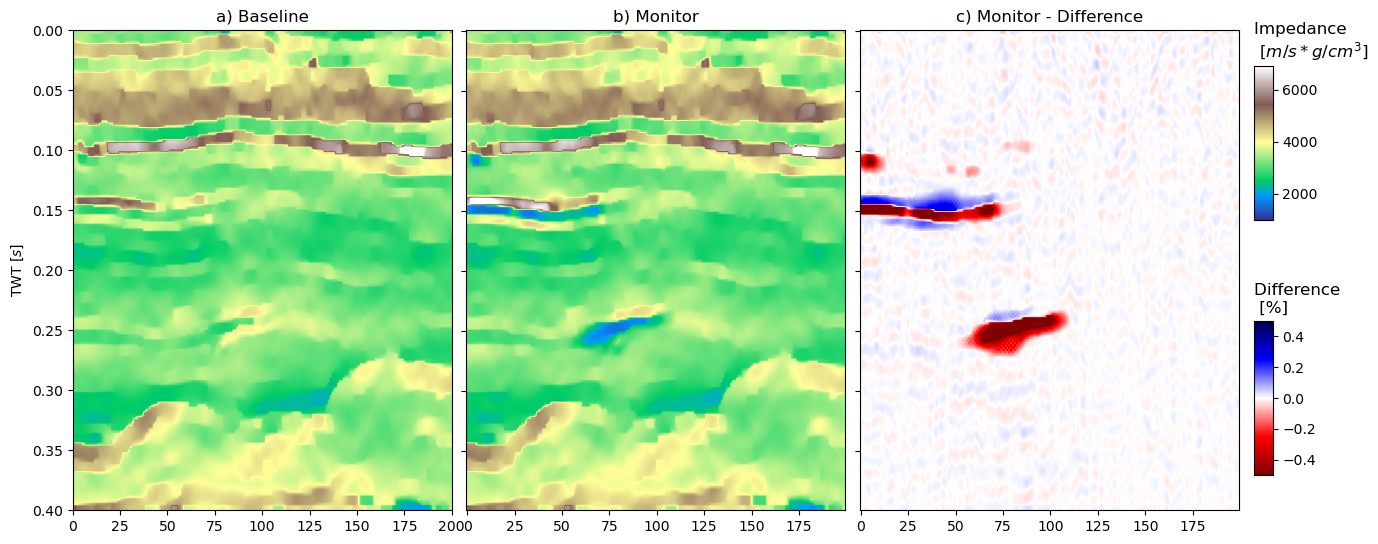

In [32]:
i = 20
plotter_4D(imp_jointb[:, :, i], imp_jointm[:, :, i], type='impedance', perc=3, dif_scale=0.5, dt=dt, height=6,
           ref=imp_L2b)

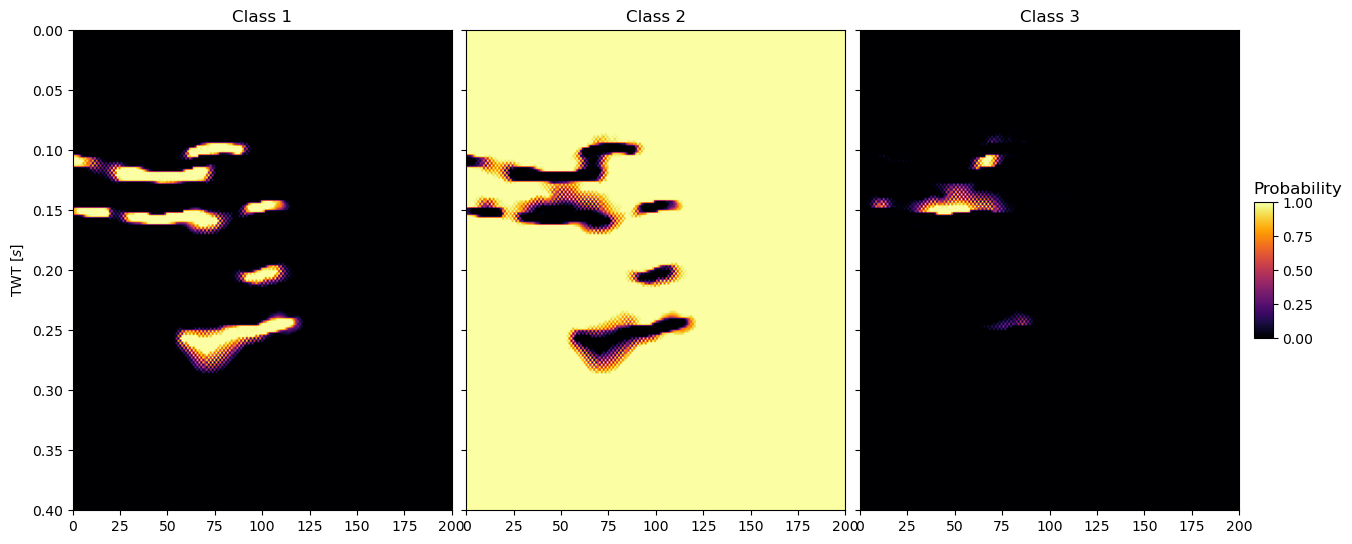

In [16]:
vjoint_line = vjoint_[:, :, i, :].reshape(nt * nx, vjoint.shape[1])
plotter_4D_seg(vjoint_line, nt, nx, dt, height=6)

## 3D Visualization

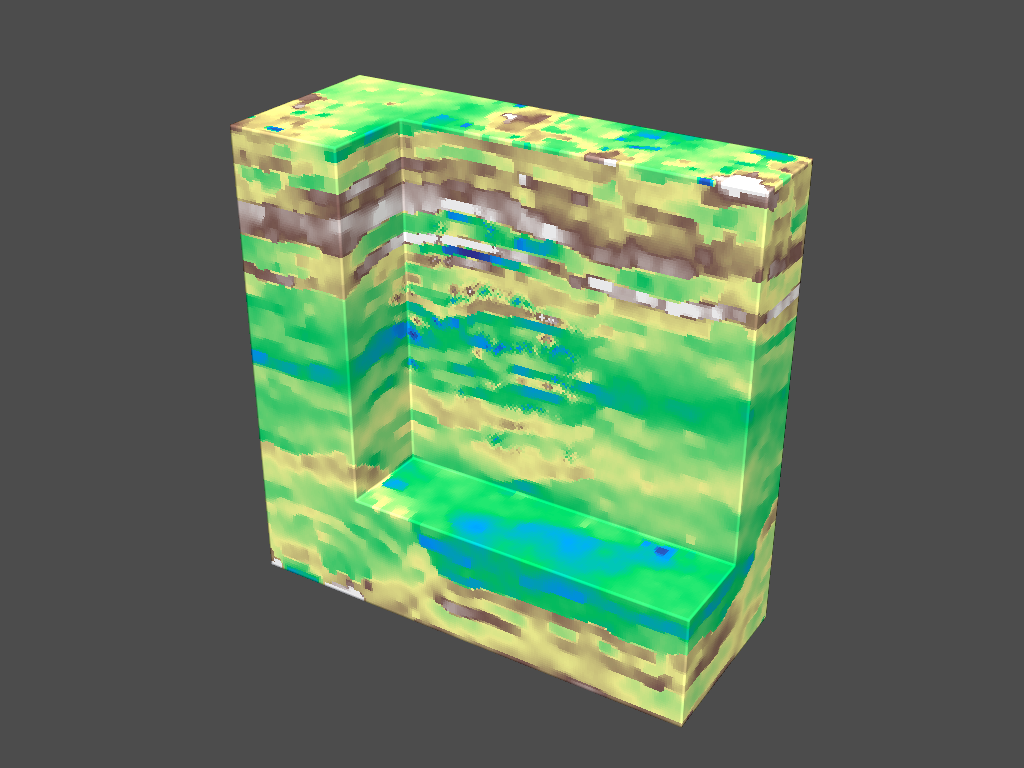

In [46]:
perc = 5
vmin, vmax = np.percentile(imp_L2b, [perc, 100 - perc])

# Small model
m_small = imp_jointb.transpose(2,1,0)
grid = pv.UniformGrid(dims=np.array(m_small.shape) + 1)
grid.cell_data["values"] = np.flip(m_small, axis=-1).flatten(order="F")
clipped = grid.clip_box([40., 200., 50., 200., 50., 200.])

# # Large model
# m_small = imp_jointb[:2,:2,:2].transpose(2,1,0)
# grid = pv.UniformGrid(dims=np.array(m_small.shape) + 1)
# grid.cell_data["values"] = np.flip(m_small, axis=-1).flatten(order="F")
# clipped = grid.clip_box(bounds=[60., 125., 50., 234., 60., 3180.])

p = pv.Plotter()
p.add_mesh(clipped, cmap='terrain', clim=[vmin, vmax],
           smooth_shading=True, metallic=1, show_scalar_bar=False)
p.camera_position = [8, 5, 5]
light = pv.Light(light_type='camera light', intensity=0.6)
p.add_light(light)
p.show()

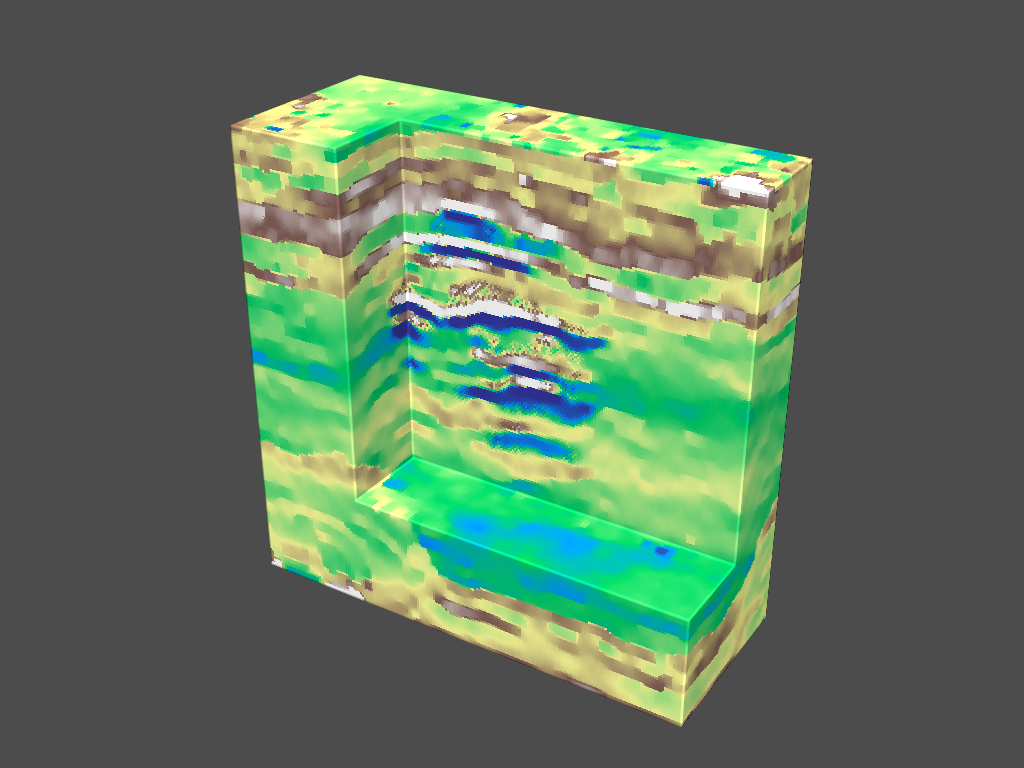

In [47]:
perc = 5
vmin, vmax = np.percentile(imp_L2b, [perc, 100 - perc])

# Small model
m_small = imp_jointm.transpose(2,1,0)
grid = pv.UniformGrid(dims=np.array(m_small.shape) + 1)
grid.cell_data["values"] = np.flip(m_small, axis=-1).flatten(order="F")
clipped = grid.clip_box([40., 200., 50., 200., 50., 200.])

# # Large model
# m_small = imp_jointm[:2,:2,:2].transpose(2,1,0)
# grid = pv.UniformGrid(dims=np.array(m_small.shape) + 1)
# grid.cell_data["values"] = np.flip(m_small, axis=-1).flatten(order="F")
# clipped = grid.clip_box(bounds=[60., 125., 50., 234., 60., 3180.])

p = pv.Plotter()
p.add_mesh(clipped, cmap='terrain', clim=[vmin, vmax],
           smooth_shading=True, metallic=1, show_scalar_bar=False)
p.camera_position = [8, 5, 5]
light = pv.Light(light_type='camera light', intensity=0.6)
p.add_light(light)
p.show()

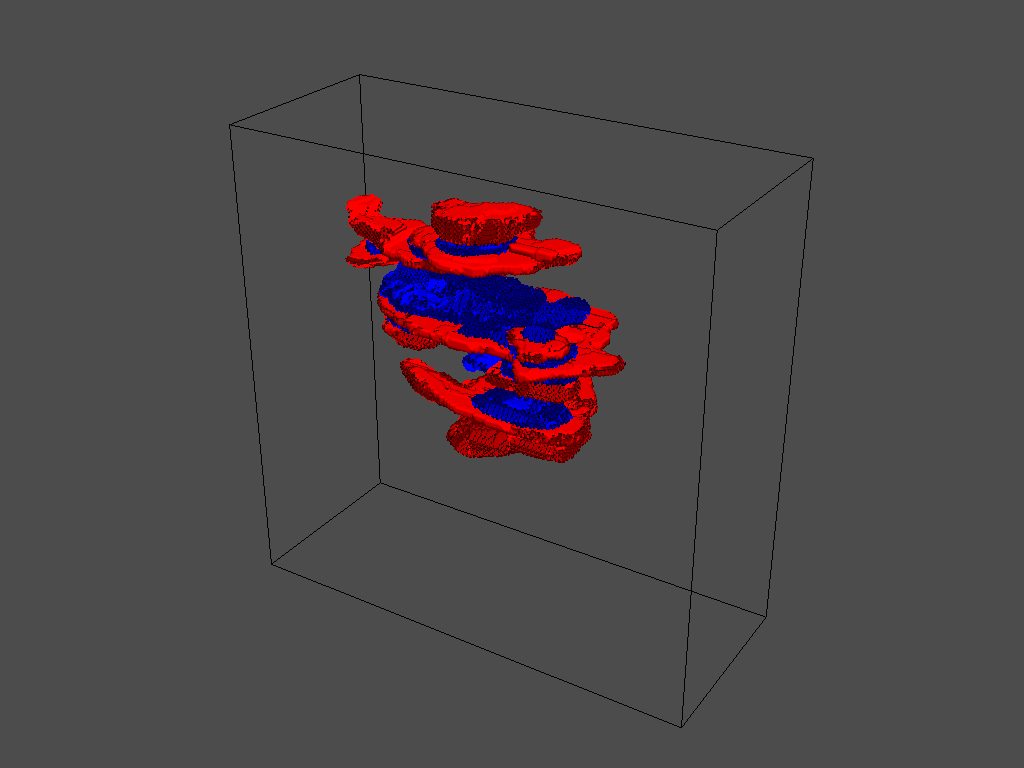

In [48]:
su_small = vcljoint.transpose(2,1,0)
sd_small = vcljoint.transpose(2,1,0)*-1
## Large model
# su_small = vcljoint[50:-50, 120:280, 380:550].transpose(2,1,0)
# sd_small = vcljoint[50:-50, 120:280, 380:550].transpose(2,1,0)*-1
grid1 = pv.UniformGrid(dims=np.array(su_small.shape) + 1)
grid1.cell_data["values"] = np.flip(su_small, axis=-1).flatten(order="F")
threshed1 = grid1.threshold(value=1.5, invert=False)
grid2 = pv.UniformGrid(dims=np.array(sd_small.shape) + 1)
grid2.cell_data["values"] = np.flip(sd_small, axis=-1).flatten(order="F")
threshed2 = grid2.threshold(value=-0.5, invert=False)
p = pv.Plotter()
outline = grid1.outline()
p.add_mesh(outline, color="k")
p.add_mesh(threshed1, color='blue', diffuse=0.8, smooth_shading=True)
p.add_mesh(threshed2, color='red', diffuse=0.8, smooth_shading=True)
p.camera_position = [8, 5, 5]
light = pv.Light(light_type='camera light', intensity=0.6)
p.add_light(light)
p.show()